+ Nguyễn Đức Toàn - 19522362

+ Link Github: https://github.com/tndTool/DataMining.git

**I. Feature Engineering**



In [ ]:
import numpy as np
import pandas as pd
data = pd.read_csv('/content/elonmusk_tweets.csv')
print(len(data))
data.head()

2819


,id,created_at,text
0,849636868052275200,2017-04-05 14:56:29,b'And so the robots spared humanity ... https:...
1,848988730585096192,2017-04-03 20:01:01,"b""@ForIn2020 @waltmossberg @mims @defcon_5 Exa..."
2,848943072423497728,2017-04-03 16:59:35,"b'@waltmossberg @mims @defcon_5 Et tu, Walt?'"
3,848935705057280001,2017-04-03 16:30:19,b'Stormy weather in Shortville ...'
4,848416049573658624,2017-04-02 06:05:23,"b""@DaveLeeBBC @verge Coal is dying due to nat ..."


1. Text Normalization

In [ ]:
from __future__ import print_function, division
from nltk.stem import PorterStemmer, WordNetLemmatizer
import nltk
nltk.download('punkt')
import string
from nltk.corpus import stopwords
import math
from collections import Counter
nltk.download('stopwords')
import pprint 
pp = pprint.PrettyPrinter(indent=4)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def normalize(document):
    # TODO: remove punctuation
    text = "".join([ch for ch in document if ch not in string.punctuation])
    
    # TODO: tokenize text
    tokens = nltk.word_tokenize(text)
    
    # TODO: Stemming
    stemmer = PorterStemmer()
    ret = " ".join([stemmer.stem(word.lower()) for word in tokens])
    return ret

original_documents = [x.strip() for x in data['text']] 
documents = [normalize(d).split() for d in original_documents]
documents[0]

['band', 'so', 'the', 'robot', 'spare', 'human', 'httpstcov7jujqwfcv']

2. Implement TF-IDF 

In [ ]:
# Flatten all the documents
flat_list = [word for doc in documents for word in doc]

# TODO: remove stop words from the vocabulary
words = [word for word in flat_list if word not in stopwords.words('english')]

# TODO: we take the 500 most common words only
counts = Counter(words)
vocabulary = counts.most_common(500)
print([x for x in vocabulary if x[0] == 'tesla'])
vocabulary = [x[0] for x in vocabulary]
assert len(vocabulary) == 500

# vocabulary.sort()
vocabulary[:5]

[('tesla', 287)]


['brt', 'tesla', 'spacex', 'model', 'thi']

In [ ]:
def tf(vocabulary, documents):
    matrix = [0] * len(documents)
    for i, document in enumerate(documents):
        counts = Counter(document)
        matrix[i] = [0] * len(vocabulary)
        for j, term in enumerate(vocabulary):
            matrix[i][j] = counts[term]
    return matrix

tf = tf(vocabulary, documents)
np.array(vocabulary)[np.where(np.array(tf[1]) > 0)], np.array(tf[1])[np.where(np.array(tf[1]) > 0)]

(array(['tesla', 'exactli'], dtype='<U17'), array([1, 1]))

In [ ]:
def idf(vocabulary, documents):
    """TODO: compute IDF, storing values in a dictionary"""
    idf = {}
    num_documents = len(documents)
    for i, term in enumerate(vocabulary):
            idf[term] = math.log(num_documents / sum(term in document for document in documents), 2)
    return idf

idf = idf(vocabulary, documents)
[idf[key] for key in vocabulary[:5]]

[2.539126825495932,
 3.3163095197385393,
 3.7262581423445837,
 3.8171115727956972,
 3.8027562798186274]

In [ ]:
def vectorize(document, vocabulary, idf):
    vector = [0]*len(vocabulary)
    counts = Counter(document)
    for i,term in enumerate(vocabulary):
        vector[i] = idf[term] * counts[term]
    return vector

document_vectors = [vectorize(s, vocabulary, idf) for s in documents]
np.array(vocabulary)[np.where(np.array(document_vectors[1]) > 0)], np.array(document_vectors[1])[np.where(np.array(document_vectors[1]) > 0)]

(array(['tesla', 'exactli'], dtype='<U17'), array([3.31630952, 6.65361284]))

3. Compare the results with the reference implementation of scikit-learn library. 

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1,1), min_df = 1, stop_words = 'english', max_features=500)

features = tfidf.fit(original_documents)
corpus_tf_idf = tfidf.transform(original_documents) 

sum_words = corpus_tf_idf.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in tfidf.vocabulary_.items()]
print(sorted(words_freq, key = lambda x: x[1], reverse=True)[:5])
print('testla', corpus_tf_idf[1, features.vocabulary_['tesla']])

[('http', 163.54366542841234), ('https', 151.85039944652075), ('rt', 112.61998731390989), ('tesla', 95.96401470715628), ('xe2', 88.20944486346477)]
testla 0.3495243100660956


4. Apply TF-IDF for information retrieval

In [ ]:
def cosine_similarity(v1,v2):
    """TODO: compute cosine similarity"""
    sumxx, sumxy, sumyy = 0, 0, 0
    for i in range(len(v1)):
        x = v1[i]; y = v2[i]
        sumxx += x*x
        sumyy += y*y
        sumxy += x*y
    if sumxy == 0:
            result = 0
    else:
            result = sumxy/math.sqrt(sumxx*sumyy)
    return result

def search_vec(query, k, vocabulary, stemmer, document_vectors, original_documents):
    q = query.split()
    q = [stemmer.stem(w) for w in q]
    query_vector = vectorize(q, vocabulary, idf)
    
    # TODO: rank the documents by cosine similarity
    scores = [[cosine_similarity(query_vector, document_vectors[d]), d] for d in range(len(document_vectors))]
    scores.sort(key=lambda x: -x[0])
    
    print('Top-{0} documents'.format(k))
    for i in range(k):
        print(i, original_documents[scores[i][1]])

query = "tesla nasa"
stemmer = PorterStemmer()
search_vec(query, 5, vocabulary, stemmer, document_vectors, original_documents)

Top-5 documents
0 b'@ashwin7002 @NASA @faa @AFPAA We have not ruled that out.'
1 b'RT @NASA: Updated @SpaceX #Dragon #ISS rendezvous times: NASA TV coverage begins Sunday at 3:30amET: http://t.co/qrm0Dz4jPE. Grapple at  ...'
2 b"Deeply appreciate @NASA's faith in @SpaceX. We will do whatever it takes to make NASA and the American people proud."
3 b'Would also like to congratulate @Boeing, fellow winner of the @NASA commercial crew program'
4 b"@astrostephenson We're aiming for late 2015, but NASA needs to have overlapping capability to be safe. Would do the same"


In [ ]:
new_features = tfidf.transform([query])

cosine_similarities = linear_kernel(new_features, corpus_tf_idf).flatten()
related_docs_indices = cosine_similarities.argsort()[::-1]

topk = 5
print('Top-{0} documents'.format(topk))
for i in range(topk):
    print(i, original_documents[related_docs_indices[i]])

Top-5 documents
0 b'@ashwin7002 @NASA @faa @AFPAA We have not ruled that out.'
1 b"SpaceX could not do this without NASA. Can't express enough appreciation. https://t.co/uQpI60zAV7"
2 b'@NASA launched a rocket into the northern lights http://t.co/tR2cSeMV'
3 b'Whatever happens today, we could not have done it without @NASA, but errors are ours alone and me most of all.'
4 b'RT @NASA: Updated @SpaceX #Dragon #ISS rendezvous times: NASA TV coverage begins Sunday at 3:30amET: http://t.co/qrm0Dz4jPE. Grapple at  ...'


**II. Text Processing**

1. Preprocessing 

In [142]:
# Import NLTK and all the needed libraries
import nltk
nltk.download('punkt') #Run this line one time to get the resource
nltk.download('stopwords') #Run this line one time to get the resource
nltk.download('wordnet') #Run this line one time to get the resource
nltk.download('averaged_perceptron_tagger') #Run this line one time to get the resource
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize
import string
import numpy as np
import pandas as pd

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [143]:
data = pd.read_csv('/content/coldplay.csv')
print(len(data))
data.head()

120


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Artist,Song,Link,Lyrics
0,Coldplay,Another's Arms,/c/coldplay/anothers+arms_21079526.html,Late night watching tv \nUsed to be you here ...
1,Coldplay,Bigger Stronger,/c/coldplay/bigger+stronger_20032648.html,I want to be bigger stronger drive a faster ca...
2,Coldplay,Daylight,/c/coldplay/daylight_20032625.html,"To my surprise, and my delight \nI saw sunris..."
3,Coldplay,Everglow,/c/coldplay/everglow_21104546.html,"Oh, they say people come \nThey say people go..."
4,Coldplay,Every Teardrop Is A Waterfall,/c/coldplay/every+teardrop+is+a+waterfall_2091...,"I turn the music up, I got my records on \nI ..."


In [144]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Artist  120 non-null    object
 1   Song    120 non-null    object
 2   Link    120 non-null    object
 3   Lyrics  120 non-null    object
dtypes: object(4)
memory usage: 3.9+ KB
None


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [145]:
# 1. Select the song 'Every Teardrop Is A Waterfall'
song = data[data['Song'] == 'Every Teardrop Is A Waterfall']['Lyrics'].values[0]
song

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


"I turn the music up, I got my records on  \nI shut the world outside until the lights come on  \nMaybe the streets alight, maybe the trees are gone  \nI feel my heart start beating to my favourite song  \n  \nAnd all the kids they dance, all the kids all night  \nUntil Monday morning feels another life  \nI turn the music up  \nI'm on a roll this time  \nAnd heaven is in sight  \n  \nI turn the music up, I got my records on  \nFrom underneath the rubble sing a rebel song  \nDon't want to see another generation drop  \nI'd rather be a comma than a full stop  \n  \nMaybe I'm in the black, maybe I'm on my knees  \nMaybe I'm in the gap between the two trapezes  \nBut my heart is beating and my pulses start  \nCathedrals in my heart  \n  \nAs we saw oh this light I swear you, emerge blinking into  \nTo tell me it's alright  \nAs we soar walls, every siren is a symphony  \nAnd every tear's a waterfall  \nIs a waterfall  \nOh  \nIs a waterfall  \nOh oh oh  \nIs a is a waterfall  \nEvery tear

In [146]:
# 2. Tokenize the lyrics of the song and save the tokens into a variable and print it
tokens = word_tokenize(song)
tokens

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['I',
 'turn',
 'the',
 'music',
 'up',
 ',',
 'I',
 'got',
 'my',
 'records',
 'on',
 'I',
 'shut',
 'the',
 'world',
 'outside',
 'until',
 'the',
 'lights',
 'come',
 'on',
 'Maybe',
 'the',
 'streets',
 'alight',
 ',',
 'maybe',
 'the',
 'trees',
 'are',
 'gone',
 'I',
 'feel',
 'my',
 'heart',
 'start',
 'beating',
 'to',
 'my',
 'favourite',
 'song',
 'And',
 'all',
 'the',
 'kids',
 'they',
 'dance',
 ',',
 'all',
 'the',
 'kids',
 'all',
 'night',
 'Until',
 'Monday',
 'morning',
 'feels',
 'another',
 'life',
 'I',
 'turn',
 'the',
 'music',
 'up',
 'I',
 "'m",
 'on',
 'a',
 'roll',
 'this',
 'time',
 'And',
 'heaven',
 'is',
 'in',
 'sight',
 'I',
 'turn',
 'the',
 'music',
 'up',
 ',',
 'I',
 'got',
 'my',
 'records',
 'on',
 'From',
 'underneath',
 'the',
 'rubble',
 'sing',
 'a',
 'rebel',
 'song',
 'Do',
 "n't",
 'want',
 'to',
 'see',
 'another',
 'generation',
 'drop',
 'I',
 "'d",
 'rather',
 'be',
 'a',
 'comma',
 'than',
 'a',
 'full',
 'stop',
 'Maybe',
 'I',
 "'m",

In [147]:
# 3. Remove the punctuation, then save the result into a variable and print it
tokens_no_punct = [token for token in tokens if token not in string.punctuation]
tokens_no_punct

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['I',
 'turn',
 'the',
 'music',
 'up',
 'I',
 'got',
 'my',
 'records',
 'on',
 'I',
 'shut',
 'the',
 'world',
 'outside',
 'until',
 'the',
 'lights',
 'come',
 'on',
 'Maybe',
 'the',
 'streets',
 'alight',
 'maybe',
 'the',
 'trees',
 'are',
 'gone',
 'I',
 'feel',
 'my',
 'heart',
 'start',
 'beating',
 'to',
 'my',
 'favourite',
 'song',
 'And',
 'all',
 'the',
 'kids',
 'they',
 'dance',
 'all',
 'the',
 'kids',
 'all',
 'night',
 'Until',
 'Monday',
 'morning',
 'feels',
 'another',
 'life',
 'I',
 'turn',
 'the',
 'music',
 'up',
 'I',
 "'m",
 'on',
 'a',
 'roll',
 'this',
 'time',
 'And',
 'heaven',
 'is',
 'in',
 'sight',
 'I',
 'turn',
 'the',
 'music',
 'up',
 'I',
 'got',
 'my',
 'records',
 'on',
 'From',
 'underneath',
 'the',
 'rubble',
 'sing',
 'a',
 'rebel',
 'song',
 'Do',
 "n't",
 'want',
 'to',
 'see',
 'another',
 'generation',
 'drop',
 'I',
 "'d",
 'rather',
 'be',
 'a',
 'comma',
 'than',
 'a',
 'full',
 'stop',
 'Maybe',
 'I',
 "'m",
 'in',
 'the',
 'black'

In [148]:
# 4. remove the stop words using NLTK. Then put the result into a variable and print it
stop_words = set(stopwords.words('english'))
tokens_no_stop_words = [token for token in tokens_no_punct if token.lower() not in stop_words]
tokens_no_stop_words

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['turn',
 'music',
 'got',
 'records',
 'shut',
 'world',
 'outside',
 'lights',
 'come',
 'Maybe',
 'streets',
 'alight',
 'maybe',
 'trees',
 'gone',
 'feel',
 'heart',
 'start',
 'beating',
 'favourite',
 'song',
 'kids',
 'dance',
 'kids',
 'night',
 'Monday',
 'morning',
 'feels',
 'another',
 'life',
 'turn',
 'music',
 "'m",
 'roll',
 'time',
 'heaven',
 'sight',
 'turn',
 'music',
 'got',
 'records',
 'underneath',
 'rubble',
 'sing',
 'rebel',
 'song',
 "n't",
 'want',
 'see',
 'another',
 'generation',
 'drop',
 "'d",
 'rather',
 'comma',
 'full',
 'stop',
 'Maybe',
 "'m",
 'black',
 'maybe',
 "'m",
 'knees',
 'Maybe',
 "'m",
 'gap',
 'two',
 'trapezes',
 'heart',
 'beating',
 'pulses',
 'start',
 'Cathedrals',
 'heart',
 'saw',
 'oh',
 'light',
 'swear',
 'emerge',
 'blinking',
 'tell',
 "'s",
 'alright',
 'soar',
 'walls',
 'every',
 'siren',
 'symphony',
 'every',
 'tear',
 "'s",
 'waterfall',
 'waterfall',
 'Oh',
 'waterfall',
 'Oh',
 'oh',
 'oh',
 'waterfall',
 'Every',


In [149]:
# 5. Perform lemmatization using WordNetLemmatizer on our tokens
lemmatizer = WordNetLemmatizer()
tokens_lemmatized = [lemmatizer.lemmatize(token) for token in tokens_no_stop_words]
tokens_lemmatized

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['turn',
 'music',
 'got',
 'record',
 'shut',
 'world',
 'outside',
 'light',
 'come',
 'Maybe',
 'street',
 'alight',
 'maybe',
 'tree',
 'gone',
 'feel',
 'heart',
 'start',
 'beating',
 'favourite',
 'song',
 'kid',
 'dance',
 'kid',
 'night',
 'Monday',
 'morning',
 'feel',
 'another',
 'life',
 'turn',
 'music',
 "'m",
 'roll',
 'time',
 'heaven',
 'sight',
 'turn',
 'music',
 'got',
 'record',
 'underneath',
 'rubble',
 'sing',
 'rebel',
 'song',
 "n't",
 'want',
 'see',
 'another',
 'generation',
 'drop',
 "'d",
 'rather',
 'comma',
 'full',
 'stop',
 'Maybe',
 "'m",
 'black',
 'maybe',
 "'m",
 'knee',
 'Maybe',
 "'m",
 'gap',
 'two',
 'trapeze',
 'heart',
 'beating',
 'pulse',
 'start',
 'Cathedrals',
 'heart',
 'saw',
 'oh',
 'light',
 'swear',
 'emerge',
 'blinking',
 'tell',
 "'s",
 'alright',
 'soar',
 'wall',
 'every',
 'siren',
 'symphony',
 'every',
 'tear',
 "'s",
 'waterfall',
 'waterfall',
 'Oh',
 'waterfall',
 'Oh',
 'oh',
 'oh',
 'waterfall',
 'Every',
 'tear',
 'w

In [150]:
# 6. use the function pos_tag of NLTK to perform POS-tagging and print the result
pos_tagged = nltk.pos_tag(tokens_lemmatized)
pos_tagged

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('turn', 'NN'),
 ('music', 'NN'),
 ('got', 'VBD'),
 ('record', 'NN'),
 ('shut', 'NN'),
 ('world', 'NN'),
 ('outside', 'IN'),
 ('light', 'JJ'),
 ('come', 'VBP'),
 ('Maybe', 'NNP'),
 ('street', 'NN'),
 ('alight', 'VBD'),
 ('maybe', 'RB'),
 ('tree', 'JJ'),
 ('gone', 'VBN'),
 ('feel', 'JJ'),
 ('heart', 'NN'),
 ('start', 'NN'),
 ('beating', 'VBG'),
 ('favourite', 'NN'),
 ('song', 'NN'),
 ('kid', 'NN'),
 ('dance', 'NN'),
 ('kid', 'NN'),
 ('night', 'NN'),
 ('Monday', 'NNP'),
 ('morning', 'NN'),
 ('feel', 'NN'),
 ('another', 'DT'),
 ('life', 'NN'),
 ('turn', 'NN'),
 ('music', 'NN'),
 ("'m", 'VBP'),
 ('roll', 'JJ'),
 ('time', 'NN'),
 ('heaven', 'VBN'),
 ('sight', 'JJ'),
 ('turn', 'NN'),
 ('music', 'NN'),
 ('got', 'VBD'),
 ('record', 'JJ'),
 ('underneath', 'NN'),
 ('rubble', 'JJ'),
 ('sing', 'VBG'),
 ('rebel', 'NN'),
 ('song', 'VBP'),
 ("n't", 'RB'),
 ('want', 'VB'),
 ('see', 'VB'),
 ('another', 'DT'),
 ('generation', 'NN'),
 ('drop', 'NN'),
 ("'d", 'MD'),
 ('rather', 'RB'),
 ('comma', 'VB'),
 

In [155]:
from nltk.corpus import wordnet

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [157]:
# 7. Perform the lemmatization properly
lemmatizer = WordNetLemmatizer()
pos_tagged_lemmatized = []
for word, tag in pos_tagged:
    pos = get_wordnet_pos(tag)
    lemmatized_word = lemmatizer.lemmatize(word, pos=pos)
    pos_tagged_lemmatized.append((lemmatized_word, tag))
pos_tagged_lemmatized

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('turn', 'NN'),
 ('music', 'NN'),
 ('get', 'VBD'),
 ('record', 'NN'),
 ('shut', 'NN'),
 ('world', 'NN'),
 ('outside', 'IN'),
 ('light', 'JJ'),
 ('come', 'VBP'),
 ('Maybe', 'NNP'),
 ('street', 'NN'),
 ('alight', 'VBD'),
 ('maybe', 'RB'),
 ('tree', 'JJ'),
 ('go', 'VBN'),
 ('feel', 'JJ'),
 ('heart', 'NN'),
 ('start', 'NN'),
 ('beat', 'VBG'),
 ('favourite', 'NN'),
 ('song', 'NN'),
 ('kid', 'NN'),
 ('dance', 'NN'),
 ('kid', 'NN'),
 ('night', 'NN'),
 ('Monday', 'NNP'),
 ('morning', 'NN'),
 ('feel', 'NN'),
 ('another', 'DT'),
 ('life', 'NN'),
 ('turn', 'NN'),
 ('music', 'NN'),
 ("'m", 'VBP'),
 ('roll', 'JJ'),
 ('time', 'NN'),
 ('heaven', 'VBN'),
 ('sight', 'JJ'),
 ('turn', 'NN'),
 ('music', 'NN'),
 ('get', 'VBD'),
 ('record', 'JJ'),
 ('underneath', 'NN'),
 ('rubble', 'JJ'),
 ('sing', 'VBG'),
 ('rebel', 'NN'),
 ('song', 'VBP'),
 ("n't", 'RB'),
 ('want', 'VB'),
 ('see', 'VB'),
 ('another', 'DT'),
 ('generation', 'NN'),
 ('drop', 'NN'),
 ("'d", 'MD'),
 ('rather', 'RB'),
 ('comma', 'VB'),
 ('ful

In [158]:
# 8. Perform stemming
stemmer = PorterStemmer()
tokens_stemmed = [stemmer.stem(token) for token in tokens_no_stop_words]
tokens_stemmed

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['turn',
 'music',
 'got',
 'record',
 'shut',
 'world',
 'outsid',
 'light',
 'come',
 'mayb',
 'street',
 'alight',
 'mayb',
 'tree',
 'gone',
 'feel',
 'heart',
 'start',
 'beat',
 'favourit',
 'song',
 'kid',
 'danc',
 'kid',
 'night',
 'monday',
 'morn',
 'feel',
 'anoth',
 'life',
 'turn',
 'music',
 "'m",
 'roll',
 'time',
 'heaven',
 'sight',
 'turn',
 'music',
 'got',
 'record',
 'underneath',
 'rubbl',
 'sing',
 'rebel',
 'song',
 "n't",
 'want',
 'see',
 'anoth',
 'gener',
 'drop',
 "'d",
 'rather',
 'comma',
 'full',
 'stop',
 'mayb',
 "'m",
 'black',
 'mayb',
 "'m",
 'knee',
 'mayb',
 "'m",
 'gap',
 'two',
 'trapez',
 'heart',
 'beat',
 'puls',
 'start',
 'cathedr',
 'heart',
 'saw',
 'oh',
 'light',
 'swear',
 'emerg',
 'blink',
 'tell',
 "'s",
 'alright',
 'soar',
 'wall',
 'everi',
 'siren',
 'symphoni',
 'everi',
 'tear',
 "'s",
 'waterfal',
 'waterfal',
 'oh',
 'waterfal',
 'oh',
 'oh',
 'oh',
 'waterfal',
 'everi',
 'tear',
 'waterfal',
 'oh',
 'oh',
 'oh',
 'hurt',


2. Bag-of-words

In [159]:
# Import NLTK and all the needed libraries
import nltk
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [160]:
data = pd.read_csv('/content/coldplay.csv')
print(len(data))
data.head()

120


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Artist,Song,Link,Lyrics
0,Coldplay,Another's Arms,/c/coldplay/anothers+arms_21079526.html,Late night watching tv \nUsed to be you here ...
1,Coldplay,Bigger Stronger,/c/coldplay/bigger+stronger_20032648.html,I want to be bigger stronger drive a faster ca...
2,Coldplay,Daylight,/c/coldplay/daylight_20032625.html,"To my surprise, and my delight \nI saw sunris..."
3,Coldplay,Everglow,/c/coldplay/everglow_21104546.html,"Oh, they say people come \nThey say people go..."
4,Coldplay,Every Teardrop Is A Waterfall,/c/coldplay/every+teardrop+is+a+waterfall_2091...,"I turn the music up, I got my records on \nI ..."


In [161]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Artist  120 non-null    object
 1   Song    120 non-null    object
 2   Link    120 non-null    object
 3   Lyrics  120 non-null    object
dtypes: object(4)
memory usage: 3.9+ KB
None


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [163]:
# 1. Compute a BOW to format: (120, 1569)
vectorizer = CountVectorizer()
bow = vectorizer.fit_transform(data['Lyrics'].values)
bow_df = pd.DataFrame(bow.toarray(), columns=vectorizer.get_feature_names_out())
print(bow_df.shape)

(120, 1776)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [164]:
# 2. Create a new dataframe containing the BOW outputs and the corresponding words as columns. And print it
bow_words_df = pd.concat([data[['Artist', 'Song']], bow_df], axis=1)
print(bow_words_df)

       Artist                           Song  10  2000  2gether  76543  \
0    Coldplay                 Another's Arms   0     0        0      0   
1    Coldplay                Bigger Stronger   0     0        0      0   
2    Coldplay                       Daylight   0     0        0      0   
3    Coldplay                       Everglow   0     0        0      0   
4    Coldplay  Every Teardrop Is A Waterfall   0     0        0      0   
..        ...                            ...  ..   ...      ...    ...   
115  Coldplay           Hymn For The Weekend   0     0        0      0   
116  Coldplay                    In My Place   0     0        0      0   
117  Coldplay                            Ink   0     0        1      0   
118  Coldplay              Ladder To The Sun   0     0        0      0   
119  Coldplay                           Lost   0     0        0      0   

     aaaaaah  aaaaah  aaaah  about  ...  yellow  yes  yesterday  yet  you  \
0          0       0      0      0

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [166]:
# 3. Find the most common word in the BOW
sum_bow = bow_df.sum()
most_common_word = sum_bow.idxmax()
most_common_word

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'you'

In [167]:
# 4. Print the 10 most used words by Coldplay
coldplay_bow_df = bow_words_df[bow_words_df['Artist'] == 'Coldplay']
coldplay_sum_bow = coldplay_bow_df.iloc[:, 2:].sum()
top_10_words = coldplay_sum_bow.nlargest(10)
print(top_10_words)

you    994
the    777
and    650
to     481
it     458
oh     334
in     318
me     314
my     288
on     285
dtype: int64


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**III. Text Similarity**

1. Similarity metrics

In [ ]:
# import needed libraries
import nltk
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
A = "Outside the classroom, Stallman pursued his studies with even more diligence, rushing off to fulfill his laboratory-assistant duties at Rockefeller University during the week and dodging the Vietnam protesters on his way to Saturday school at Columbia. It was there, while the rest of the Science Honors Program students sat around discussing their college choices, that Stallman finally took a moment to participate in the preclass bull session."
B = "To facilitate the process, AI Lab hackers had built a system that displayed both the source and display modes on a split screen. Despite this innovative hack, switching from mode to mode was still a nuisance."
C = "With no dorm and no dancing, Stallman's social universe imploded. Like an astronaut experiencing the aftereffects of zero-gravity, Stallman found that his ability to interact with nonhackers, especially female nonhackers, had atrophied significantly. After 16 weeks in the AI Lab, the self confidence he'd been quietly accumulating during his 4 years at Harvard was virtually gone."

In [ ]:
# Split the sentences
A_list = A.split()
B_list = B.split()
C_list = C.split()

# Compute the intersection and union
A_set = set(A_list)
B_set = set(B_list)
C_set = set(C_list)
AB_intersection = A_set.intersection(B_set)
AB_union = A_set.union(B_set)
AC_intersection = A_set.intersection(C_set)
AC_union = A_set.union(C_set)
BC_intersection = B_set.intersection(C_set)
BC_union = B_set.union(C_set)

# Compute and print the Jaccard Similarity
AB_jaccard = len(AB_intersection) / len(AB_union)
AC_jaccard = len(AC_intersection) / len(AC_union)
BC_jaccard = len(BC_intersection) / len(BC_union)

In [ ]:
print("Jaccard Similarity AB:", AB_jaccard)
print("Jaccard Similarity BC:", BC_jaccard)
print("Jaccard Similarity AC:", AC_jaccard)

Jaccard Similarity AB: 0.08536585365853659
Jaccard Similarity BC: 0.09210526315789473
Jaccard Similarity AC: 0.125


In [ ]:
corpus = [A, B, C]

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(corpus)

cosine_sim_matrix = cosine_similarity(tfidf_matrix)

print(f"cos(A, B): [[{cosine_sim_matrix[0][1]}]]")
print(f"cos(B, C): [[{cosine_sim_matrix[1][2]}]]")
print(f"cos(A, C): [[{cosine_sim_matrix[0][2]}]]")

cos(A, B): [[0.16793269576264072]]
cos(B, C): [[0.13618963113796592]]
cos(A, C): [[0.2850296032333907]]


-- Is it consistent with the Jaccard values? --

No, the cosine similarity values are not consistent with the Jaccard values. The Jaccard similarity values indicate that sentences A and C as well as sentences B and C share some common words, while sentences A and B have no common words. However, the cosine similarity values indicate that sentences A and C as well as sentences C and A have the highest similarity, while all other pairs of sentences have no similarity. This discrepancy may be due to the fact that Jaccard similarity only compares the overlap in the set of words between two sentences, while cosine similarity takes into account the frequency of each word in the sentences as well.

2. TF-IDF 

In [ ]:
# Import needed modules
import pandas as pd
import numpy as np
import string
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
df = pd.read_csv('/content/headlines.csv')
print(len(df))
df.head()

1999


,publish_date,headline_text
0,20170721,algorithms can make decisions on behalf of fed...
1,20170721,andrew forrests fmg to appeal pilbara native t...
2,20170721,a rural mural in thallan
3,20170721,australia church risks becoming haven for abusers
4,20170721,australian company usgfx embroiled in shanghai...


In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999 entries, 0 to 1998
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   publish_date   1999 non-null   int64 
 1   headline_text  1999 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB
None


In [ ]:
# Define a function for preprocessing
def preprocess(text):
    # Tokenize
    tokens = word_tokenize(text.lower())
    # Remove punctuation
    tokens = [word for word in tokens if word not in string.punctuation]
    # Remove stop words
    stop_words = stopwords.words('english')
    tokens = [word for word in tokens if word not in stop_words]
    # Stem
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]

    return ' '.join(tokens)


# Apply the preprocessing function to the 'headline_text' column
df['headline_text'] = df['headline_text'].apply(preprocess)

# Print the output
print(df['headline_text'])

0                algorithm make decis behalf feder minist
1       andrew forrest fmg appeal pilbara nativ titl rule
2                                     rural mural thallan
3                        australia church risk becom abus
4       australian compani usgfx embroil shanghai staf...
                              ...                        
1994    constitut avenu win top prize act architectu a...
1995                              dark mofo number crunch
1996    david petraeu say australia must firm south ch...
1997    driverless car australia face challeng roo pro...
1998                     drug compani criticis price hike
Name: headline_text, Length: 1999, dtype: object


In [ ]:
bow = CountVectorizer()
bow_matrix = bow.fit_transform(df['headline_text'])

# Print the shape ofthe BOW representation
print(bow_matrix.shape)

(1999, 4256)


In [ ]:
# Compute the TF using the BOW
tf = bow_matrix.toarray()
tf = np.divide(tf, np.sum(tf, axis=1, keepdims=True))
print(tf)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
# Compute the IDF
idf = np.log(np.divide(len(df['headline_text']), np.count_nonzero(bow_matrix.toarray(), axis=0)))
idf

array([7.60040233, 7.60040233, 7.60040233, ..., 7.60040233, 7.60040233,
       7.60040233])

In [ ]:
# Compute the TF-IDF
tf_idf = np.multiply(tf, idf)
tf_idf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
# Print the 10 words with the highest and lowest TF-IDF on average
vocab = bow.get_feature_names_out()
tf_idf_avg = np.mean(tf_idf, axis=0)
sorted_indices = tf_idf_avg.argsort()

print('10 words with the highest TF-IDF on average:')
for i in range(1, 11):
    word = vocab[sorted_indices[-i]]
    print(f'{word}: {tf_idf_avg[sorted_indices[-i]]:.4f}')
    
print('10 words with the lowest TF-IDF on average:')
for i in range(1, 11):
    word = vocab[sorted_indices[i-1]]
    print(f'{word}: {tf_idf_avg[sorted_indices[i-1]]:.4f}')

10 words with the highest TF-IDF on average:
australian: 0.0197
australia: 0.0197
new: 0.0170
polic: 0.0145
say: 0.0143
market: 0.0138
trump: 0.0133
wa: 0.0127
man: 0.0125
sydney: 0.0119
10 words with the lowest TF-IDF on average:
haw: 0.0003
geel: 0.0003
adel: 0.0003
coll: 0.0003
nmfc: 0.0003
gw: 0.0003
melb: 0.0003
gcfc: 0.0003
syd: 0.0003
nemtsov: 0.0003


In [ ]:
# Compute the TF-IDF using scikit learn
tf_idf_sk = TfidfVectorizer()
tf_idf_matrix = tf_idf_sk.fit_transform(df['headline_text'])

# Print the 10 words with the highest and lowest TF-IDF on average using scikit learn
vocab_sk = tf_idf_sk.get_feature_names_out()
tf_idf_avg_sk = np.mean(tf_idf_matrix.toarray(), axis=0)
sorted_indices_sk = tf_idf_avg_sk.argsort()

print('10 words with the highest TF-IDF on average using scikit learn:')
for i in range(1, 11):
    word = vocab_sk[sorted_indices_sk[-i]]
    print(f'{word}: {tf_idf_avg_sk[sorted_indices_sk[-i]]:.4f}')
    
print('10 words with the lowest TF-IDF on average using scikit learn:')
for i in range(1, 11):
    word = vocab_sk[sorted_indices_sk[i-1]]
    print(f'{word}: {tf_idf_avg_sk[sorted_indices_sk[i-1]]:.4f}')

10 words with the highest TF-IDF on average using scikit learn:
australia: 0.0100
australian: 0.0097
new: 0.0087
polic: 0.0077
say: 0.0076
trump: 0.0068
man: 0.0065
wa: 0.0063
charg: 0.0060
sydney: 0.0057
10 words with the lowest TF-IDF on average using scikit learn:
adel: 0.0002
melb: 0.0002
haw: 0.0002
coll: 0.0002
gw: 0.0002
syd: 0.0002
gcfc: 0.0002
nmfc: 0.0002
geel: 0.0002
fabio: 0.0002


3. Plagiarism checker 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score

with open('A1.txt', 'r') as file:
    A1 = file.readlines()[0]
with open('Asource.txt', 'r') as file:
    A0 = file.readlines()[0]
with open('B1.txt', 'r') as file:
    B1 = file.readlines()[0]
with open('Bsource.txt', 'r') as file:
    B0 = file.readlines()[0]
with open('C1.txt', 'r') as file:
    C1 = file.readlines()[0]
with open('Csource.txt', 'r') as file:
    C0 = file.readlines()[0]
with open('D1.txt', 'r') as file:
    D1 = file.readlines()[0]
with open('D2.txt', 'r') as file:
    D2 = file.readlines()[0]
with open('Dsource.txt', 'r') as file:
    D0 = file.readlines()[0]

In [ ]:
C0

'Descartes has been heralded as the first modern philosopher. He is famous for having made an important connection between geometry and algebra, which allowed for the solving of geometrical problems by way of algebraic equations. He is also famous for having promoted a new conception of matter, which allowed for the accounting of physical phenomena by way of mechanical explanations. However, he is most famous for having written a relatively short work, Meditationes de Prima Philosophia (Meditations On First Philosophy), published in 1641, in which he provides a philosophical groundwork for the possibility of the sciences. (Smith, 2007).\n'

In [ ]:
# Create a list of all documents
alldata = [A0, A1, B0, B1, C0, C1, D0, D1, D2]

In [ ]:
# Compute tf-idf for all documents
tfvect = TfidfVectorizer()
tfvect.fit(alldata)
tfidf = tfvect.transform(alldata)

TFIDFA = tfvect.transform([A0, A1]).toarray()
TFIDFB = tfvect.transform([B0, B1]).toarray()
TFIDFC = tfvect.transform([C0, C1]).toarray()
TFIDFD = tfvect.transform([D0, D1, D2]).toarray()

In [ ]:
# Compute pair-wise similarity
similarityAA = cosine_similarity(TFIDFA)
similarityBB = cosine_similarity(TFIDFB)
similarityCC = cosine_similarity(TFIDFC)
similarityDD = cosine_similarity(TFIDFD)

similarityAll = cosine_similarity(tfidf)

In [ ]:
similarityAA

array([[1.        , 0.81898863],
       [0.81898863, 1.        ]])

In [ ]:
similarityBB

array([[1.        , 0.63747903],
       [0.63747903, 1.        ]])

In [ ]:
similarityCC

array([[1.        , 0.85723864],
       [0.85723864, 1.        ]])

In [ ]:
similarityDD

array([[1.        , 0.92754461, 0.45775827],
       [0.92754461, 1.        , 0.47179638],
       [0.45775827, 0.47179638, 1.        ]])

In [ ]:
similarityAll

array([[1.        , 0.81898863, 0.10748497, 0.12736224, 0.24491604,
        0.29501242, 0.2530779 , 0.2146434 , 0.18585492],
       [0.81898863, 1.        , 0.10940658, 0.12644471, 0.21239125,
        0.25583485, 0.214717  , 0.17937458, 0.16807197],
       [0.10748497, 0.10940658, 1.        , 0.63747903, 0.08804551,
        0.09372089, 0.08509508, 0.07946359, 0.10627147],
       [0.12736224, 0.12644471, 0.63747903, 1.        , 0.08730757,
        0.08893992, 0.12527568, 0.1207279 , 0.12910021],
       [0.24491604, 0.21239125, 0.08804551, 0.08730757, 1.        ,
        0.85723864, 0.20151171, 0.16200275, 0.14447728],
       [0.29501242, 0.25583485, 0.09372089, 0.08893992, 0.85723864,
        1.        , 0.22326634, 0.1806631 , 0.1558733 ],
       [0.2530779 , 0.214717  , 0.08509508, 0.12527568, 0.20151171,
        0.22326634, 1.        , 0.92754461, 0.45775827],
       [0.2146434 , 0.17937458, 0.07946359, 0.1207279 , 0.16200275,
        0.1806631 , 0.92754461, 1.        , 0.47179638],


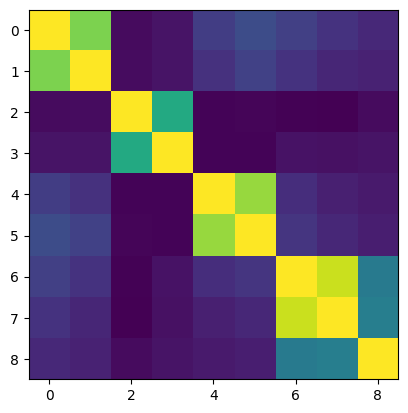

In [ ]:
# Show pair-wise similarity
plt.imshow(similarityAll)
plt.show()

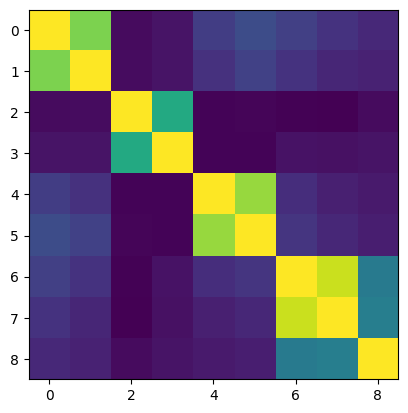

In [ ]:
import matplotlib.pyplot as plt

# Compute the pairwise cosine similarity between all documents
similarityAll = cosine_similarity(tfidf)

pred_plagiarism = similarityAll > 0.2

# Plot the pairwise similarity matrix as a heatmap
plt.imshow(similarityAll)
plt.show()

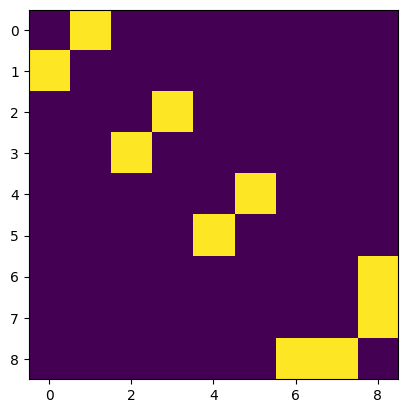

In [ ]:
# Build the true labels matrix
documents = ['A0', 'A1', 'B0', 'B1', 'C0', 'C1', 'D0', 'D1', 'D2']
doc_index = {doc: i for i, doc in enumerate(documents)}
labels = [('A0', 'A1', 1), ('A0', 'B0', 0), ('A0', 'B1', 0), ('A0', 'C0', 0), ('A0', 'C1', 0), ('A0', 'D0', 0), ('A0', 'D1', 0), ('A0', 'D2', 0), ('A1', 'B0', 0), ('A1', 'B1', 0), ('A1', 'C0', 0), ('A1', 'C1', 0), ('A1', 'D0', 0), ('A1', 'D1', 0), ('A1', 'D2', 0), ('B0', 'B1', 1), ('B0', 'C0', 0), ('B0', 'C1', 0), ('B0', 'D0', 0), ('B0', 'D1', 0), ('B0', 'D2', 0), ('B1', 'C0', 0), ('B1', 'C1', 0), ('B1', 'D0', 0), ('B1', 'D1', 0), ('B1', 'D2', 0), ('C0', 'C1', 1), ('C0', 'D0', 0), ('C0', 'D1', 0), ('C0', 'D2', 0), ('C1', 'D0', 0), ('C1', 'D1', 0), ('C1', 'D2', 0), ('D0', 'D1', 0), ('D0', 'D2', 1), ('D1', 'D2', 1)]

real_plagiarism = np.zeros((9,9))
for label in labels:
    i = doc_index[label[0]]
    j = doc_index[label[1]]
    real_plagiarism[i][j] = label[2]
    real_plagiarism[j][i] = label[2]

plt.imshow(real_plagiarism)
plt.show()

In [ ]:
# Compute the accuracy score based on true matrices
pred_plagiarism = similarityAll > 0.2
acc_score = accuracy_score(real_plagiarism.flatten(), pred_plagiarism.flatten())

print('Accuracy score:', acc_score)

Accuracy score: 0.6419753086419753


**IV. Text Classification**

In [ ]:
# Import NLTK and all the needed libraries
import nltk
nltk.download('wordnet')
import numpy as np
import pandas as pd
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# TODO: Load the dataset 
df = pd.read_csv('spam.csv', encoding='latin-1')
df.head(5)

,Class,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
# TODO: explore the dataset
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Class    5572 non-null   object
 1   Message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [ ]:
# TODO: Perform preprocessing over all the text

# Rename the columns of the dataset to `Class` and `Message`
df.columns = ['Class', 'Message']

# Convert the text to lowercase
df['Message'] = df['Message'].str.lower()

# Remove non-alphanumeric characters
df['Message'] = df['Message'].str.replace('[^a-zA-Z0-9 ]', '', regex=True)

# Remove stop words
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
df['tokens'] = df['Message'].apply(lambda x: [word for word in x.split() if word not in stop_words])

# Stem words
stemmer = PorterStemmer()
df['tokens'] = df['tokens'].apply(lambda x: [stemmer.stem(word) for word in x])

# Lemmatize words
lemmatizer = WordNetLemmatizer()
df['tokens'] = df['tokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

# Print the tokens column
print(df['tokens'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0       [go, jurong, point, crazi, avail, bugi, n, gre...
1                            [ok, lar, joke, wif, u, oni]
2       [free, entri, 2, wkli, comp, win, fa, cup, fin...
3           [u, dun, say, earli, hor, u, c, alreadi, say]
4       [nah, dont, think, goe, usf, live, around, tho...
                              ...                        
5567    [2nd, time, tri, 2, contact, u, u, 750, pound,...
5568                          [b, go, esplanad, fr, home]
5569                         [piti, mood, soani, suggest]
5570    [guy, bitch, act, like, id, interest, buy, som...
5571                                   [rofl, true, name]
Name: tokens, Length: 5572, dtype: object


In [ ]:
# Create a CountVectorizer object
vectorizer = CountVectorizer()

# Compute the Bag of Words (BOW)
bow = vectorizer.fit_transform(df['Message'])
print(bow.shape)

(5572, 9539)


In [ ]:
# Create a new dataframe with the BOW
bow_df = pd.DataFrame(bow.toarray(), columns=vectorizer.get_feature_names_out())

# Print the new dataframe with the BOW
print(bow_df)

      008704050406  0089my  0121  01223585236  01223585334  0125698789  02  \
0                0       0     0            0            0           0   0   
1                0       0     0            0            0           0   0   
2                0       0     0            0            0           0   0   
3                0       0     0            0            0           0   0   
4                0       0     0            0            0           0   0   
...            ...     ...   ...          ...          ...         ...  ..   
5567             0       0     0            0            0           0   0   
5568             0       0     0            0            0           0   0   
5569             0       0     0            0            0           0   0   
5570             0       0     0            0            0           0   0   
5571             0       0     0            0            0           0   0   

      020603  0207  02070836089  ...  zebra  zed  zeros  zhong 

In [ ]:
# Compute the sum of word frequencies for each class
spam_word_freq = bow_df[df['Class'] == 'spam'].sum()
ham_word_freq = bow_df[df['Class'] == 'ham'].sum()

# Find the most frequent word in each class
most_freq_spam_word = spam_word_freq.idxmax()
most_freq_ham_word = ham_word_freq.idxmax()

# Print the most frequent words in each class
print(f"most frequent spam word: {most_freq_spam_word}")
print(f"most frequent non-spam word: {most_freq_ham_word}")

most frequent spam word: to
most frequent non-spam word: you


In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(bow, df['Class'], test_size=0.2, random_state=42)

# Train a logistic regression model
lr = LogisticRegression()
lr.fit(X_train, y_train)

# Predict the class labels for the testing set
y_pred = lr.predict(X_test)

# Compute the accuracy of the classifier
accuracy = lr.score(X_test, y_test)

# Print the predicted class labels for the testing set
print(y_pred)

# Print the accuracy of the classifier
print(accuracy)

['ham' 'ham' 'spam' ... 'ham' 'ham' 'ham']
0.9775784753363229


**V. Topic Modelling**

In [82]:
# TODO: import needed libraries
import re
import pandas as pd
import numpy as np
import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from gensim import corpora, models

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [83]:
df = pd.read_csv('random_headlines.csv')
print(df.shape)
print(df.head())

(20000, 2)
   publish_date                          headline_text
0      20120305  ute driver hurt in intersection crash
1      20081128           6yo dies in cycling accident
2      20090325          bumper olive harvest expected
3      20100201     replica replaces northernmost sign
4      20080225           woods targets perfect season


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [84]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   publish_date   20000 non-null  int64 
 1   headline_text  20000 non-null  object
dtypes: int64(1), object(1)
memory usage: 312.6+ KB
None


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [85]:
# Define a function for preprocessing
def preprocess(text):
    # Tokenize
    tokens = word_tokenize(text.lower())
    # Remove punctuation
    tokens = [word for word in tokens if word not in string.punctuation]
    # Remove stop words
    stop_words = stopwords.words('english')
    tokens = [word for word in tokens if word not in stop_words]
    # Stem
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]

    return tokens

# Apply the preprocessing function to the 'headline_text' column
df['stemmed'] = df['headline_text'].apply(preprocess)

# Print the output
print(df['stemmed'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0                    [ute, driver, hurt, intersect, crash]
1                                  [6yo, die, cycl, accid]
2                          [bumper, oliv, harvest, expect]
3                    [replica, replac, northernmost, sign]
4                          [wood, target, perfect, season]
                               ...                        
19995               [judg, attack, walkinshaw, run, arrow]
19996           [polish, govt, collaps, elect, held, next]
19997                              [drum, friday, may, 29]
19998            [winterbottom, bathurst, provision, pole]
19999    [pull, pork, pawpaw, salad, local, success, st...
Name: stemmed, Length: 20000, dtype: object


In [86]:
# TODO: Compute the BOW using Gensim
dictionary = corpora.Dictionary(df['stemmed'])

bow_corpus = df['stemmed'].apply(dictionary.doc2bow)

print(bow_corpus.shape)
print(bow_corpus.head())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(20000,)
0    [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]
1            [(5, 1), (6, 1), (7, 1), (8, 1)]
2         [(9, 1), (10, 1), (11, 1), (12, 1)]
3        [(13, 1), (14, 1), (15, 1), (16, 1)]
4        [(17, 1), (18, 1), (19, 1), (20, 1)]
Name: stemmed, dtype: object


In [87]:
# TODO: Compute TF-IDF
# Convert the bow_corpus Series to a list of tuples
bow_corpus_tuples = [doc for doc in df['stemmed'].apply(dictionary.doc2bow)]

# Create a TF-IDF model from the list of tuples
tfidf = models.TfidfModel(bow_corpus_tuples)

# Create a Pandas series of the TF-IDF representation of each document
tfidf_corpus = df['stemmed'].apply(lambda x: tfidf[dictionary.doc2bow(x)])

# Print the shape and example of the TF-IDF corpus
print(tfidf_corpus.shape)
print(tfidf_corpus.head())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(20000,)
0    [(0, 0.30725466582280214), (1, 0.3528943781678...
1    [(5, 0.6996935746626014), (6, 0.40368931479963...
2    [(9, 0.6052255513921649), (10, 0.3803963291388...
3    [(13, 0.6213509318780707), (14, 0.401977885755...
4    [(17, 0.5937887452228604), (18, 0.432499245079...
Name: stemmed, dtype: object


In [88]:
# TODO: Compute LSA

lsa = models.LsiModel(tfidf_corpus, id2word=dictionary, num_topics=5)

for i, topic in enumerate(lsa.show_topics()):
    print(f"{topic}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gensim/models/lsimodel.py:963: DeprecationWarning: Please use `csc_matvecs` from the `scipy.sparse` namespace, the `scipy.sparse.sparsetools` namespace is deprecated.
  sparsetools.csc_matvecs(


(0, '-0.459*"man" + -0.389*"polic" + -0.314*"charg" + -0.148*"court" + -0.146*"murder" + -0.131*"face" + -0.110*"crash" + -0.110*"miss" + -0.109*"new" + -0.102*"death"')
(1, '-0.435*"second" + -0.408*"90" + -0.337*"abc" + -0.297*"news" + -0.287*"weather" + 0.236*"man" + -0.236*"busi" + -0.180*"sport" + 0.163*"charg" + -0.104*"plan"')
(2, '-0.373*"man" + -0.272*"second" + -0.266*"charg" + -0.260*"90" + 0.217*"plan" + 0.202*"govt" + 0.190*"council" + 0.175*"new" + -0.171*"abc" + -0.160*"weather"')
(3, '-0.766*"polic" + 0.246*"man" + 0.214*"charg" + -0.173*"investig" + -0.161*"probe" + 0.140*"court" + 0.131*"council" + 0.130*"plan" + 0.104*"govt" + 0.103*"face"')
(4, '-0.716*"abc" + 0.436*"second" + 0.382*"90" + -0.154*"market" + -0.137*"sport" + -0.126*"entertain" + -0.122*"busi" + -0.099*"weather" + -0.082*"analysi" + 0.068*"council"')


In [89]:
# TODO: Print the 3 or 4 most significant words of each topic

for i, topic in enumerate(lsa.show_topics()):
    words = topic[1].split(' + ')
    print(f"Topic {i}: {words[:4]}")

Topic 0: ['-0.459*"man"', '-0.389*"polic"', '-0.314*"charg"', '-0.148*"court"']
Topic 1: ['-0.435*"second"', '-0.408*"90"', '-0.337*"abc"', '-0.297*"news"']
Topic 2: ['-0.373*"man"', '-0.272*"second"', '-0.266*"charg"', '-0.260*"90"']
Topic 3: ['-0.766*"polic"', '0.246*"man"', '0.214*"charg"', '-0.173*"investig"']
Topic 4: ['-0.716*"abc"', '0.436*"second"', '0.382*"90"', '-0.154*"market"']


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [90]:
# TODO: Compute LDA
lda = models.LdaModel(tfidf_corpus, id2word=dictionary, num_topics=5)

# Print the topics and their most frequent words
for i, topic in enumerate(lda.show_topics()):
    print(f"{topic}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(0, '0.004*"interview" + 0.004*"plan" + 0.003*"fund" + 0.003*"govt" + 0.003*"back" + 0.002*"new" + 0.002*"tiger" + 0.002*"pressur" + 0.002*"job" + 0.002*"tourism"')
(1, '0.004*"review" + 0.004*"countri" + 0.003*"court" + 0.003*"accus" + 0.003*"win" + 0.003*"man" + 0.003*"hour" + 0.003*"sale" + 0.003*"may" + 0.003*"hear"')
(2, '0.008*"polic" + 0.007*"man" + 0.006*"charg" + 0.005*"car" + 0.004*"woman" + 0.004*"murder" + 0.004*"miss" + 0.004*"kill" + 0.004*"found" + 0.004*"crash"')
(3, '0.004*"market" + 0.003*"australian" + 0.003*"rate" + 0.003*"rise" + 0.003*"mine" + 0.003*"compani" + 0.003*"price" + 0.003*"png" + 0.003*"interview" + 0.002*"act"')
(4, '0.005*"second" + 0.004*"abc" + 0.004*"news" + 0.004*"weather" + 0.004*"coast" + 0.003*"90" + 0.003*"us" + 0.003*"gold" + 0.003*"new" + 0.003*"road"')


In [91]:
# TODO: print the most frequent words of each topic
for i, topic in enumerate(lda.show_topics()):
    words = topic[1].split(' + ')
    print(f"Topic {i}: {words[:4]}")

Topic 0: ['0.004*"interview"', '0.004*"plan"', '0.003*"fund"', '0.003*"govt"']
Topic 1: ['0.004*"review"', '0.004*"countri"', '0.003*"court"', '0.003*"accus"']
Topic 2: ['0.008*"polic"', '0.007*"man"', '0.006*"charg"', '0.005*"car"']
Topic 3: ['0.004*"market"', '0.003*"australian"', '0.003*"rate"', '0.003*"rise"']
Topic 4: ['0.005*"second"', '0.004*"abc"', '0.004*"news"', '0.004*"weather"']


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [99]:
# import pyLDAvis
# import pyLDAvis.gensim 

# # Create the LDA visualization
# lda_display = pyLDAvis.gensim.prepare(lda, tfidf_corpus, dictionary, sort_topics=False)

# # Launch the visualization
# pyLDAvis.display(lda_display)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**VI. Named Entity Recognition**

In [112]:
# TODO : Imports
import spacy
from spacy import displacy

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [113]:
# TODO : load file and have a look at it
with open('ada_lovelace.txt', 'r') as f:
    text = f.read()
text

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'Augusta Ada King, Countess of Lovelace (née Byron; 10 December 1815 – 27 November 1852) was an English mathematician and writer, chiefly known for her work on Charles Babbage\'s proposed mechanical general-purpose computer, the Analytical Engine. She was the first to recognise that the machine had applications beyond pure calculation, and published the first algorithm intended to be carried out by such a machine. As a result, she is sometimes regarded as the first to recognise the full potential of a "computing machine" and one of the first computer programmers. \n\nLovelace became close friends with her tutor Mary Somerville, who introduced her to Charles Babbage in 1833. She had a strong respect and affection for Somerville, and they corresponded for many years. Other acquaintances included the scientists Andrew Crosse, Sir David Brewster, Charles Wheatstone, Michael Faraday and the author Charles Dickens.'

In [114]:
# TODO : Named Entities Recognition
nlp = spacy.load('en_core_web_sm')
doc = nlp(text)
for ent in doc.ents:
    print(ent.text, ent.label_)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Augusta Ada King PERSON
Countess PERSON
Lovelace PERSON
Byron ORG
10 December 1815 DATE
27 November 1852 DATE
English LANGUAGE
Charles Babbage's ORG
the Analytical Engine ORG
first ORDINAL
first ORDINAL
first ORDINAL
one CARDINAL
first ORDINAL
Lovelace PERSON
Mary Somerville PERSON
Charles Babbage PERSON
1833 DATE
Somerville GPE
many years DATE
Andrew Crosse PERSON
David Brewster PERSON
Charles Wheatstone PERSON
Michael Faraday PERSON
Charles Dickens PERSON


In [115]:
# TODO : NER visualization
displacy.render(doc, style='ent', jupyter=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [116]:
# TODO : `replace_name_by_redacted`
def replace_name_by_redacted(token):
    if token.ent_type_ == 'PERSON':
      return '[REDACTED]'
    else:
      return token.text

def make_doc_GDPR_compliant(doc):
    return ' '.join([replace_name_by_redacted(token) for token in doc])

compliant_text = make_doc_GDPR_compliant(doc)
compliant_text

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'[REDACTED] [REDACTED] [REDACTED] , [REDACTED] of [REDACTED] ( née Byron ; 10 December 1815 – 27 November 1852 ) was an English mathematician and writer , chiefly known for her work on Charles Babbage \'s proposed mechanical general - purpose computer , the Analytical Engine . She was the first to recognise that the machine had applications beyond pure calculation , and published the first algorithm intended to be carried out by such a machine . As a result , she is sometimes regarded as the first to recognise the full potential of a " computing machine " and one of the first computer programmers . \n\n [REDACTED] became close friends with her tutor [REDACTED] [REDACTED] , who introduced her to [REDACTED] [REDACTED] in 1833 . She had a strong respect and affection for Somerville , and they corresponded for many years . Other acquaintances included the scientists [REDACTED] [REDACTED] , Sir [REDACTED] [REDACTED] , [REDACTED] [REDACTED] , [REDACTED] [REDACTED] and the author [REDACTED] [

In [111]:
#  function make_doc_GDPR_compliant:
def make_doc_GDPR_compliant(doc):
    return ' '.join([replace_name_by_redacted(token) for token in doc])

compliant_text = make_doc_GDPR_compliant(doc)
compliant_text

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**VII. Exercise**

1. By using the job market data, finish the following task to analyze the top important keywords
for IT sector.
+ Filter the jobs for IT sector only.
+ Put the description of all jobs into a list.
+ Use scikit-learn to get top 20 important keywords.
+ Choose one favourite keyword and perform information retrieval with scikit-learn.

In [212]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# Load the job-market.csv file into a pandas DataFrame
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/job-market.csv')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [213]:
# Clean the data.
data.dropna(inplace=True)
data.drop_duplicates(inplace=True)

# Fix column datatypes.
import re

# Define a function to clean a string
def clean_string(text):
    if text:
        # Remove HTML tags
        clean = re.compile('<.*?>')
        text = re.sub(clean, '', text)
        
        # Replace '&nbsp;' and '\n *&nbsp;' with a space
        text = re.sub(r'(&nbsp;|\n *&nbsp;)', ' ', text)
        
        # Remove unwanted characters
        text = re.sub(r'\n *|\*', '', text)
        
        return text if text else None

data['Id'] = data['Id'].astype(int)
data['LowestSalary'] = data['LowestSalary'].astype(int)
data['HighestSalary'] = data['HighestSalary'].astype(int)
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%dT%H:%M:%S.%fZ')
data['LowestSalary'] = pd.to_numeric(data['LowestSalary'], errors='coerce')
data['HighestSalary'] = pd.to_numeric(data['HighestSalary'], errors='coerce')
data['FullDescription'] = data['FullDescription'].apply(clean_string)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [214]:
# Filter the jobs for IT sector only.
it_df = data[data['Classification'] == 'Information & Communication Technology']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [215]:
# Put the description of all jobs into a list.
descriptions = it_df['FullDescription'].tolist()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [216]:
# Remove any NaN values from the descriptions list
descriptions = [desc for desc in descriptions if isinstance(desc, str)]

# Use scikit-learn to get top 20 important keywords
count_vect = CountVectorizer()
X_counts = count_vect.fit_transform(descriptions)
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_counts)
feature_names = count_vect.get_feature_names_out().tolist() # convert to list
tfidf_scores = X_tfidf.toarray().sum(axis=0)
top_keywords_idx = tfidf_scores.argsort()[::-1][:20]
top_keywords = [feature_names[i] for i in top_keywords_idx]
print("Top 20 important keywords:", top_keywords)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Top 20 important keywords: ['and', 'to', 'the', 'of', 'in', 'with', 'you', 'for', 'experience', 'be', 'will', 'our', 'is', 'we', 'business', 'on', 'team', 'this', 'are', 'or']


In [217]:
favourite_keyword = "python"
keyword_idx = feature_names.index(favourite_keyword)
job_indices = X_tfidf[:, keyword_idx].nonzero()[0]
relevant_jobs = it_df.iloc[job_indices]['FullDescription']
print("Number of relevant jobs:",len(relevant_jobs))
print("Sample relevant job descriptions:\n", relevant_jobs.head())

Number of relevant jobs: 13
Sample relevant job descriptions:
 1135    Hi Everyone,Our company is seeking an energeti...
1223    About Us: Infosys is a global leader in consul...
1265    iOS Developer We are looking for a passionate ...
1446    The Client:Located in one of Melbourne's most ...
1555    JOB DESCRIPTION• Consult with BSFI customers o...
Name: FullDescription, dtype: object


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2. Implement a method capable of extracting n-grams from a given sequence object (e.g., string
and list). Utilize this feature to produce word tri-grams, letter tri-grams based on the sentence "I
like deadline and want to immerse myself in deadline."


In [173]:
def extract_ngrams(sequence, n):
    ngrams = []
    for i in range(len(sequence)-n+1):
        ngram = sequence[i:i+n]
        ngrams.append(ngram)
    return ngrams

sentence = "I like deadline and want to immerse myself in deadline."
words = sentence.split()
word_trigrams = extract_ngrams(words, 3)
print(word_trigrams)

letters = sentence.replace(" ", "")
letter_trigrams = extract_ngrams(letters, 3)
print(letter_trigrams)

[['I', 'like', 'deadline'], ['like', 'deadline', 'and'], ['deadline', 'and', 'want'], ['and', 'want', 'to'], ['want', 'to', 'immerse'], ['to', 'immerse', 'myself'], ['immerse', 'myself', 'in'], ['myself', 'in', 'deadline.']]
['Ili', 'lik', 'ike', 'ked', 'ede', 'dea', 'ead', 'adl', 'dli', 'lin', 'ine', 'nea', 'ean', 'and', 'ndw', 'dwa', 'wan', 'ant', 'ntt', 'tto', 'toi', 'oim', 'imm', 'mme', 'mer', 'ers', 'rse', 'sem', 'emy', 'mys', 'yse', 'sel', 'elf', 'lfi', 'fin', 'ind', 'nde', 'dea', 'ead', 'adl', 'dli', 'lin', 'ine', 'ne.']


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


3. Construct a program that satisfies these criteria in line with them: You will be provided with a string of words that are separated by a certain amount of space. Every time one of the following words occurs in this order: If the phrase can be written with no more than four letters, then its original form should be maintained. In any other circumstance, the opening letter and the final letter should both be kept the same. Switch out some of the letters for others and rearrange them in a chaotic sequence (in the middle of the word) Using a statement such as "I couldn't believe that I could completely understand what I was reading: the astounding power of the human mind" as an example, describe the results by providing a statement such as "I couldn't believe that I could truly comprehend what I was reading."

In [174]:
import re
import random

# Define the list of trigger words
trigger_words = ["believe", "completely", "understand", "astounding", "power", "human", "mind"]

# Define a function to process each word in the input string
def process_word(word):
    if word.lower() in trigger_words:
        if len(word) <= 4:
            return word
        else:
            first_letter = word[0]
            last_letter = word[-1]
            middle_letters = list(word[1:-1])
            random.shuffle(middle_letters)
            return first_letter + ''.join(middle_letters) + last_letter
    else:
        return word

# Define the input string
input_string = "I couldn't believe that I could completely understand what I was reading: the astounding power of the human mind"

# Split the input string into words
words = re.findall(r'\b\w+\b', input_string)

# Process each word using the process_word function
processed_words = [process_word(word) for word in words]

# Join the processed words back into a string
output_string = ' '.join(processed_words)

# Print the output string
print(output_string)

I couldn t bvielee that I could cpmtolleey unaestnrdd what I was reading the adntsinoug power of the huamn mind


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


4. The zip file alice.zip includes the text file alice.txt containing Lewis Carroll's book Alice's
Adventures in Wonderland, which is available on Project Gutenberg. Apply a part-of-speech
(POS) tagger to the text file, then save the output to a separate file. Implement programmes that
read the results of POS tagging and carry out the tasks.

In [186]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# Load the text file
with open('alice.txt', 'r') as f:
    text = f.read()

# Tokenize the text into sentences
sentences = nltk.sent_tokenize(text)

# Process each sentence and tag the parts of speech
pos_sentences = []
for sentence in sentences:
    tokens = nltk.word_tokenize(sentence)
    pos_tags = nltk.pos_tag(tokens)
    pos_sentences.append(pos_tags)

# Save the POS tagged sentences to a separate file
with open('alice_pos.txt', 'w') as f:
    for sentence in pos_sentences:
        f.write(str(sentence))
        f.write('\n')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [187]:
# Load the POS tagged file
with open('alice_pos.txt', 'r') as f:
    pos_text = f.read()

# Split the text into sentences
pos_sentences = pos_text.split('\n')

# Count the number of nouns in the text
noun_count = 0
for sentence in pos_sentences:
    for word, pos in nltk.pos_tag(nltk.word_tokenize(sentence)):
        if pos.startswith('N'):
            noun_count += 1

print("Number of nouns in the text:", noun_count)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Number of nouns in the text: 33224


In [188]:
# Load the POS tagged file
with open('alice_pos.txt', 'r') as f:
    pos_text = f.read()

# Split the text into sentences
pos_sentences = pos_text.split('\n')

# Extract all the adjectives in the text
adjectives = set()
for sentence in pos_sentences:
    for word, pos in nltk.pos_tag(nltk.word_tokenize(sentence)):
        if pos.startswith('JJ'):
            adjectives.add(word)

# Save the adjectives to a separate file
with open('alice_adjectives.txt', 'w') as f:
    for adj in adjectives:
        f.write(adj)
        f.write('\n')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [189]:
# Load the POS tagged file
with open('alice_pos.txt', 'r') as f:
    pos_text = f.read()

# Split the text into sentences
pos_sentences = pos_text.split('\n')

# Replace all the verbs in the text with their past tense forms
new_sentences = []
for sentence in pos_sentences:
    new_tokens = []
    for word, pos in nltk.pos_tag(nltk.word_tokenize(sentence)):
        if pos.startswith('V'):
            new_word = nltk.stem.WordNetLemmatizer().lemmatize(word, 'v')
            new_word = nltk.corpus.wordnet.morphy(new_word, nltk.corpus.wordnet.VERB)
            if new_word:
                new_tokens.append(new_word)
            else:
                new_tokens.append(word)
        else:
            new_tokens.append(word)
    new_sentence = ' '.join(new_tokens)

    new_sentences.append(new_sentence)

# Save the modified sentences to a separate file
with open('alice_past_tense.txt', 'w') as f:
    for sentence in new_sentences:
        f.write(sentence)
        f.write('\n')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [185]:
#END: Best luck for you, thank you!

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
